# Dog Detection CNN Model

Attempt to get my friend's attention by making them use this on their dog. Practicing with TensorFlow is nice too, I guess.

#BornToUseCamelCase_forced_to_use_snake_case

### Load dependencies

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

### Task 1: Prepare the dataset

We will be using the Stanford dogs Image Dataset from Roboflow. It contains 23 223 jpg images of dogs, labelled with bounding boxes. It's too large to commit, so you'll have to download it manually, and add it to this directory. You can download it from the site here: https://universe.roboflow.com/igor-romanica-gmail-com/stanford-dogs-0pff9. Make sure to select the Tensorflow Object Detection CSV format.

Once that's done, we can parse the data into a keras Sequence object that will serve as our dataset.

In [45]:
class DataGenerator(tf.keras.utils.Sequence):
    """
    Data Generator class. Inherits from tf.keras.utils.Sequence

    >>> batch_size = 32
    >>> image_size = (224, 224)
    >>> csv_file = 'path/to/your/annotations.csv'
    >>> image_dir = 'path/to/your/images'
    >>> data_generator = CustomDataGenerator(csv_file, image_dir, batch_size, image_size)
    """
    def __init__(self, csv_file: str, image_dir: str, batch_size: int, image_size: tuple[int, int]) -> None:
        """
        DataGenerator constructor method.
        """
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.num_samples = len(self.data)

    def __len__(self) -> int:
        return int(np.ceil(self.num_samples / self.batch_size))

    def __getitem__(self, index) -> tuple[np.array, np.array]:
        batch_data = self.data.iloc[index * self.batch_size:(index + 1) * self.batch_size]

        images = []
        annotations = []

        for _, row in batch_data.iterrows():
            image_path = row['filename']
            image = cv2.imread(os.path.join(self.image_dir, image_path))
            image = cv2.resize(image, self.image_size)
            #image = image / 255.0  # Normalize pixel values to [0, 1]

            xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
            class_label = row['class']

            # You may need to convert the coordinates to relative values or other formats as per your requirements

            images.append(image)
            annotations.append((xmin, ymin, xmax, ymax, class_label))

        return np.array(images), np.array(annotations)

In [46]:
# Create the train, test, and validation datasets
X_train = DataGenerator(
    os.getcwd() + "/Stanford dogs.v3i.tensorflow/train/_annotations.csv",
    os.getcwd() + "/Stanford dogs.v3i.tensorflow/train",
    32,
    (224, 224)
)
X_test = DataGenerator(
    os.getcwd() + "/Stanford dogs.v3i.tensorflow/test/_annotations.csv",
    os.getcwd() + "/Stanford dogs.v3i.tensorflow/test",
    32,
    (224, 224)
)
X_valid = DataGenerator(
    os.getcwd() + "/Stanford dogs.v3i.tensorflow/valid/_annotations.csv",
    os.getcwd() + "/Stanford dogs.v3i.tensorflow/valid",
    32,
    (224, 224)
)

In [43]:
# Check that data loaded properly
X_train.data.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,n02101388_1941_jpg.rf.3c607af1ab5a273782f4571c...,416,416,Brittany_spaniel,0,0,416,393
1,n02110627_8949_jpg.rf.3c46c1369619b5bb5cfdb3a1...,416,416,affenpinscher,56,5,357,416
2,n02104365_8466_jpg.rf.3c5461b0f06c5f16c429325a...,416,416,schipperke,82,28,310,416
3,n02110627_8048_jpg.rf.3c48c2201000f8ff85d61771...,416,416,affenpinscher,0,0,394,413
4,n02100877_239_jpg.rf.3c5813c61b445e08fff6c09b4...,416,416,Irish_setter,28,5,411,416


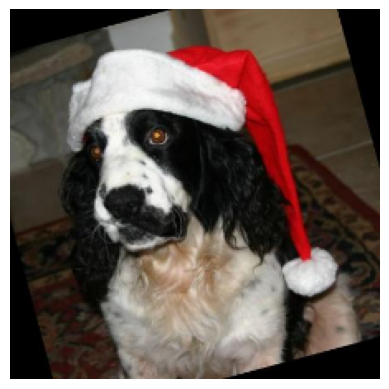

Class: English_springer


In [54]:
def display(sample: tuple[np.array, np.array], index: int) -> None:
    """
    Display the image at <index> in the given batch of images <sample> from a DataGenerator.
    """
    # get the image and it's annotations
    batchs, annotations = sample
    sample_image, sample_annotation = batchs[index], annotations[index]
    # convert from BGR (opencv default for some reason) to RGB (matplotlib default)
    sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
    plt.imshow(sample_image)
    plt.axis('off')
    plt.show()
    print(f"Class: {sample_annotation[4]}")

# View an image from the first batch
sample_batch = X_train[0]
# select an image
i = 5 # 0 <= i <= batch_size - 1
display(sample_batch, i)